### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [1]:
# import libraries

import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


In [2]:
import getpass
password = getpass.getpass()

In [3]:
# build connection to database

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [38]:
# query a view i created in mysql workbench which joins the film, rental and inventory tables and picks out the info i think is relevant for this exercise
# quantity column is the amount of times the film has been rented previously

query = '''
select * from regression_model_data

'''

### 2- Read the data into a Pandas dataframe

In [40]:
data = pd.read_sql_query(query, engine)
data

,film_id,release_year,language,quantity,price,length,rating,category
0,103,2006,English,34.0,4.99,133,PG,Travel
1,738,2006,English,33.0,0.99,178,PG-13,Foreign
2,331,2006,English,32.0,2.99,90,NC-17,Games
3,382,2006,English,32.0,0.99,137,PG,Games
4,489,2006,English,32.0,0.99,54,PG-13,Animation
...,...,...,...,...,...,...,...,...
995,909,2006,English,NaN,0.99,102,PG-13,Horror
996,943,2006,English,NaN,4.99,76,PG-13,Documentary
997,950,2006,English,NaN,4.99,132,PG,Classics
998,954,2006,English,NaN,4.99,73,G,New


### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [41]:
data.dtypes

film_id           int64
release_year      int64
language         object
quantity        float64
price           float64
length            int64
rating           object
category         object
dtype: object

In [42]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
film_id,1000.0,500.500000,288.819436,1.00,250.75,500.50,750.25,1000.00
release_year,1000.0,2006.000000,0.000000,2006.00,2006.00,2006.00,2006.00,2006.00
quantity,958.0,16.750522,6.679823,4.00,11.00,16.00,22.00,34.00
price,1000.0,2.980000,1.646393,0.99,0.99,2.99,4.99,4.99
length,1000.0,115.272000,40.426332,46.00,80.00,114.00,149.25,185.00


In [43]:
data['film_id'].value_counts()

# we have 1000 unique films in the data

1       1
672     1
659     1
660     1
661     1
       ..
339     1
340     1
341     1
342     1
1000    1
Name: film_id, Length: 1000, dtype: int64

In [44]:
data.isna().sum()

# we have 42 films which have never been rented

film_id          0
release_year     0
language         0
quantity        42
price            0
length           0
rating           0
category         0
dtype: int64

In [52]:
# remove these as they have never been rented before so 
data = data.dropna()

In [53]:
# films which have never been rented have been removed
data['quantity'].isna().sum()

0

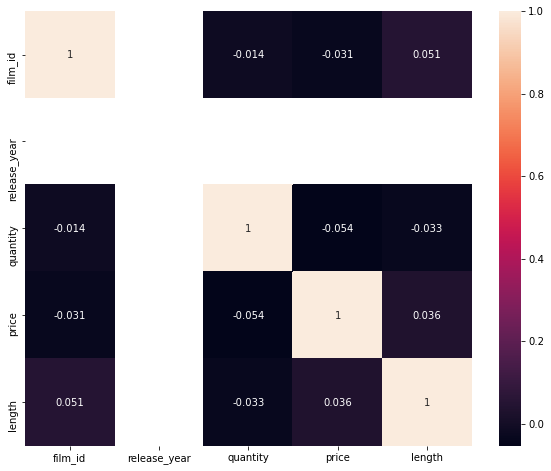

In [54]:
# check correlation of data
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

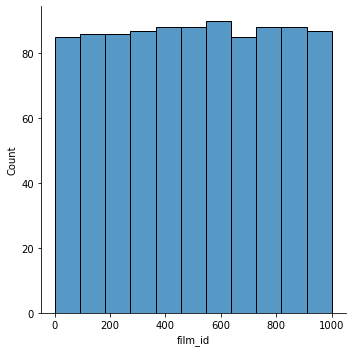

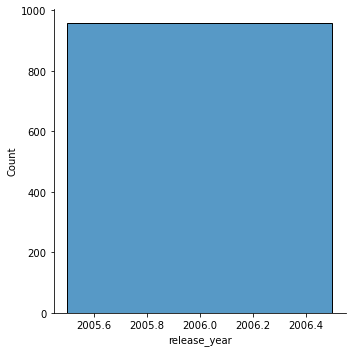

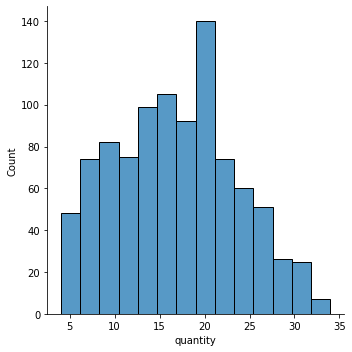

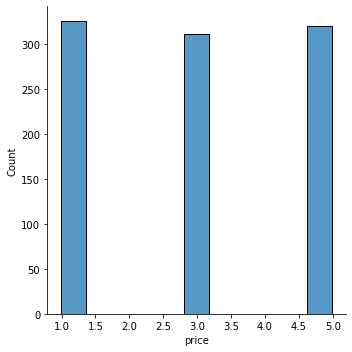

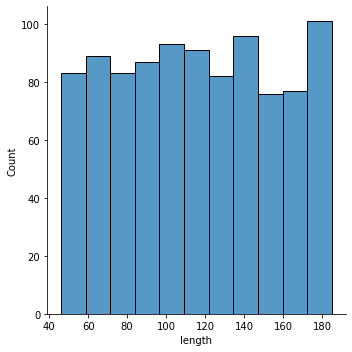

In [55]:
# check distribution of data
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

In [57]:
data.shape

(958, 8)

In [58]:
data.set_index('film_id')

,release_year,language,quantity,price,length,rating,category
film_id,,,,,,,
103,2006,English,34.0,4.99,133,PG,Travel
738,2006,English,33.0,0.99,178,PG-13,Foreign
331,2006,English,32.0,2.99,90,NC-17,Games
382,2006,English,32.0,0.99,137,PG,Games
489,2006,English,32.0,0.99,54,PG-13,Animation
...,...,...,...,...,...,...,...
781,2006,English,5.0,4.99,127,R,Games
903,2006,English,5.0,4.99,139,G,Travel
400,2006,English,4.0,2.99,72,R,Documentary


### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

# the last month in the data is februay 2006 so i wrote the query with that in mind.
# i just created a new view which lists all the distinct films and used case to return a 1 in a new column if the film was rented in february 2006 and a 0 if not.
# this is the query i used in mysql workbench
create or replace view rented_last_month as
select distinct(title),
case 
when title in 
(select title from monthly_film
where rental_month = 2 and rental_year = 2006) then true
else false
end as test
from film;


In [59]:
# this query joins my above view with the film table just to get the film_id because i forgot to add that to the view in sql and we need it to match with the above data :)

query_2 = '''
select r.title, r.test, film_id
from rented_last_month r
join film f
on f.title = r.title;
'''

In [60]:
data2 = pd.read_sql_query(query_2, engine)
data2

,title,test,film_id
0,ACADEMY DINOSAUR,0,1
1,ACE GOLDFINGER,1,2
2,ADAPTATION HOLES,0,3
3,AFFAIR PREJUDICE,1,4
4,AFRICAN EGG,1,5
...,...,...,...
995,YOUNG LANGUAGE,0,996
996,YOUTH KICK,0,997
997,ZHIVAGO CORE,1,998
998,ZOOLANDER FICTION,0,999


In [63]:
# join first df with the second (which includes the info whether the film was rented last month or not)

data_new = data.join(data2.set_index('film_id'), on='film_id')

In [68]:
# the rented_last_month column is the boolean mentioned in question 4
data_new = data_new.rename(columns={'test':'rented_last_month'})
data_new

,film_id,release_year,language,quantity,price,length,rating,category,title,rented_last_month
0,103,2006,English,34.0,4.99,133,PG,Travel,BUCKET BROTHERHOOD,0
1,738,2006,English,33.0,0.99,178,PG-13,Foreign,ROCKETEER MOTHER,0
2,331,2006,English,32.0,2.99,90,NC-17,Games,FORWARD TEMPLE,0
3,382,2006,English,32.0,0.99,137,PG,Games,GRIT CLOCKWORK,0
4,489,2006,English,32.0,0.99,54,PG-13,Animation,JUGGLER HARDLY,1
...,...,...,...,...,...,...,...,...,...,...
953,781,2006,English,5.0,4.99,127,R,Games,SEVEN SWARM,0
954,903,2006,English,5.0,4.99,139,G,Travel,TRAFFIC HOBBIT,0
955,400,2006,English,4.0,2.99,72,R,Documentary,HARDLY ROBBERS,0
956,584,2006,English,4.0,2.99,180,PG-13,Foreign,MIXED DOORS,0


### 5- Create a logistic regression model to predict this variable from the cleaned data

In [72]:
# x/y split
# also drop title column because we have the film_id
y = data_new['rented_last_month']
X = data_new.drop(['rented_last_month','title'], axis=1)

In [73]:
X = pd.get_dummies(X, columns=['category', 'rating', 'language'])
X

,film_id,release_year,quantity,price,length,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,...,category_New,category_Sci-Fi,category_Sports,category_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,language_English
0,103,2006,34.0,4.99,133,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,738,2006,33.0,0.99,178,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,331,2006,32.0,2.99,90,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,382,2006,32.0,0.99,137,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,489,2006,32.0,0.99,54,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,781,2006,5.0,4.99,127,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
954,903,2006,5.0,4.99,139,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
955,400,2006,4.0,2.99,72,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
956,584,2006,4.0,2.99,180,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [74]:
y.value_counts(normalize=True)

0    0.824635
1    0.175365
Name: rented_last_month, dtype: float64

In [75]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
len(X_test), len(X_train), len(y_train), len(y_test)

(192, 766, 766, 192)

In [77]:
# fit logistic regression model to data
classification = LogisticRegression(random_state=42, max_iter=1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### 6- Evaluate the results (calculate the score of the model)

In [78]:
# the score is 0.84 so seems relatively high
classification.score(X_test, y_test)

0.8489583333333334

In [79]:
predictions = classification.predict(X_test)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [80]:
predictions_ = classification.predict_proba(X_test)
predictions_

array([[0.89022816, 0.10977184],
       [0.88257213, 0.11742787],
       [0.80602214, 0.19397786],
       [0.9016446 , 0.0983554 ],
       [0.85725742, 0.14274258],
       [0.65251707, 0.34748293],
       [0.82354883, 0.17645117],
       [0.80741459, 0.19258541],
       [0.87730806, 0.12269194],
       [0.87856078, 0.12143922],
       [0.80387049, 0.19612951],
       [0.84456057, 0.15543943],
       [0.71514329, 0.28485671],
       [0.93743675, 0.06256325],
       [0.89392002, 0.10607998],
       [0.85560064, 0.14439936],
       [0.63523778, 0.36476222],
       [0.82610949, 0.17389051],
       [0.87370015, 0.12629985],
       [0.92196082, 0.07803918],
       [0.93794134, 0.06205866],
       [0.63886051, 0.36113949],
       [0.93100041, 0.06899959],
       [0.77218441, 0.22781559],
       [0.84210401, 0.15789599],
       [0.74591159, 0.25408841],
       [0.86394588, 0.13605412],
       [0.86433197, 0.13566803],
       [0.88157112, 0.11842888],
       [0.79257943, 0.20742057],
       [0.

In [81]:
confusion_matrix(y_test, predictions)

array([[163,   0],
       [ 29,   0]])

In [82]:
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
cf_matrix

array([[0.84895833, 0.        ],
       [0.15104167, 0.        ]])

<AxesSubplot:>

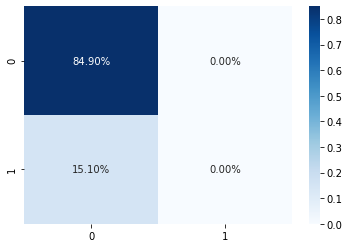

In [83]:
sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues')

<AxesSubplot:>

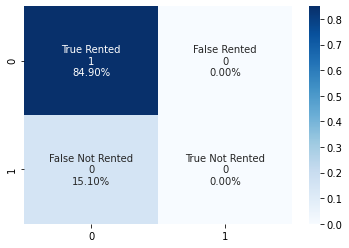

In [84]:
group_names = ['True Rented', 'False Rented', 'False Not Rented', 'True Not Rented']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
# overall seems like the kdoel did a good job of predicting the whether the film was rented or not.
# but i don't really understand how exactly it works and why the predictions were good?